# Introduction 

#### In the first part we saw some basics of Ensemble learning.... 

#### In this notebook we will try to understand some of the advanced ensemble learning methods and implement them...


<center>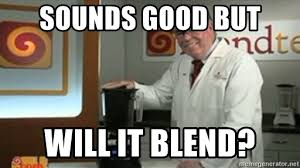</center>



#### Jokes apart, without any more delay lets get into ensemble learning

#### **NOTE :** This notebook on Ensemble Learning is divided into 2 parts and we are in **Part-2** 

## For Part-1 click [here](https://www.kaggle.com/nitindatta/ensemble-learning-part-1) 

  <font color="red" size=3>Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>
----------------------------------------------------------------------------------------------------------------------------------------------

<a class="anchor" id="toc"></a>
<div style="background: #f9f9f9 none repeat scroll 0 0;border: 1px solid #aaa;display: table;font-size: 95%;margin-bottom: 1em;padding: 20px;width: 600px;">
<h1>Contents</h1>
<ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
<li style="list-style: outside none none !important;font-size:17px"><a href="#1.1">1 Preprocessing Data</a></li>
    
<li style="list-style: outside none none !important;font-size:17px"><a href="#2.1">2 Training Base Learners</a></li>

<li style="list-style: outside none none !important;font-size:17px"><a href="#3.1">3 Advanced Ensemble Learning</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
            <li style="list-style: outside none none !important;"><a href="#3.1">3.1 Stacking</a></li>
            <li style="list-style: outside none none !important;"><a href="#3.2">3.2 Blending</a></li>
            <li style="list-style: outside none none !important;"><a href="#3.3">3.3 Bagging</a></li>
            <li style="list-style: outside none none !important;"><a href="#3.4">3.4 Boosting</a></li>           
      </ul>    
<li style="list-style: outside none none !important;font-size:17px"><a href="#4">4 Boosting In Depth</a></li>
     <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;"> 
    <li style="list-style: outside none none !important;"><a href="#4.1">4.1 XGBoost</a></li>
            <li style="list-style: outside none none !important;"><a href="#4.2">4.2 AdaBoost</a></li>
            <li style="list-style: outside none none !important;"><a href="#4.3">4.3 LightGBM</a></li>
            <li style="list-style: outside none none !important;"><a href="#4.4">4.4 CatBoost</a></li>
        

</ul>
</div>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import eli5
from eli5.sklearn import PermutationImportance
import gc


# Preprocessing the data

Below datasets are picked from [here](https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda)

<a class="anchor" id="1.1"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

In [ ]:
train_set = pd.read_csv('/kaggle/input/preprocessed-sales-data/train_set.csv')
validation_set = pd.read_csv('/kaggle/input/preprocessed-sales-data/validation_set.csv')
test_set = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [ ]:
train_set.head().T

In [ ]:
# Creating training and validation sets
x_train = train_set.drop(['item_cnt_month','date_block_num'],axis=1)
y_train = train_set['item_cnt_month'].astype(int)

x_val = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
y_val = validation_set['item_cnt_month'].astype(int)

In [ ]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
x_test = pd.merge(test_set, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
x_test['year'] = 2015
x_test['month'] = 9
x_test.drop('item_cnt_month', axis=1, inplace=True)
x_test = x_test[x_train.columns]

In [ ]:
ts = time.time()
sets = [x_train, x_val,x_test]
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median

x_test.fillna(x_test.mean(), inplace=True)
print('Time taken : ',time.time()-ts)

In [ ]:
x_test.head().T

In [ ]:
all_f = ['shop_id', 'item_id', 'item_cnt', 'mean_item_cnt', 'transactions', 'year',
       'month', 'item_cnt_mean', 'item_cnt_std',
       'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3',
       'item_trend', 'shop_mean', 'item_mean', 'shop_item_mean', 'year_mean',
       'month_mean']

We will be using only the above features

In [ ]:
x_tr = x_train[all_f]
x_va = x_val[all_f]
x_te = x_test[all_f]

# Training Base Learners
<a class="anchor" id="2.1"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
def models(model, x_tr, y_train, x_va, x_te):
    '''
    This model is used to train the model and make predictions.
    - model : the model in usage (LR, KN, RF)
    - x_tr : x_train dataframe
    - y_train : y_train dataframe
    - x_va : x_validation dataframe
    - x_te : x_test dataframe
    '''
    
    #training the model
    model.fit(x_tr,y_train)
    
    #storing the predictions for `train` and `validation` sets
    train_pred = model.predict(x_tr)
    val_pred = model.predict(x_va)
    test_pred = model.predict(x_te)
    
    return train_pred, val_pred, test_pred

In [ ]:
# Training the first model: Linear Regression
LR = LinearRegression(n_jobs=-1)
M1_train, M1_val, M1_test = models(LR,x_tr,y_train,x_va,x_te)

In [ ]:
print('Train rmse for LINEAR REGRESSION:', np.sqrt(mean_squared_error(y_train, M1_train)))
val_lr = np.sqrt(mean_squared_error(y_val, M1_val))
print('Validation rmse for LINEAR REGRESSION:', np.sqrt(mean_squared_error(y_val, M1_val)))

In [ ]:
perm = PermutationImportance(LR, random_state=42).fit(x_va, y_val)
eli5.show_weights(perm, feature_names = x_va.columns.tolist())

## How to interpret Feature Importances


1. The first number in each row shows how much model performance decreased with a random shuffling.
2. The number after the ± measures how performance varied from one-reshuffling to the next.
3. The features `shop_item_mean`, `item_cnt_mean`, `item_cnt` have higher highest impact on predictions.

In [ ]:
x_t_knn = x_tr[:100000]
y_t_knn = y_train[:100000]

scaler = MinMaxScaler()
scaler.fit(x_t_knn)
scaled_x_t_knn = scaler.transform(x_t_knn)
scaled_x_v = scaler.transform(x_va)

KN = KNeighborsRegressor(n_neighbors=20, leaf_size=15,n_jobs=-1)
M2_train, M2_val, M2_test = models(KN,scaled_x_t_knn,y_t_knn,scaled_x_v,x_te)

In [ ]:
print('Train rmse for KNN:', np.sqrt(mean_squared_error(y_t_knn, M2_train)))
val_knn = np.sqrt(mean_squared_error(y_val, M2_val))
print('Validation rmse for KNN:', np.sqrt(mean_squared_error(y_val, M2_val)))

In [ ]:
x_va_knn = x_va[:10000]
y_val_knn = y_val[:10000]
perm = PermutationImportance(KN, random_state=42).fit(x_va_knn, y_val_knn)
eli5.show_weights(perm, feature_names = x_va.columns.tolist())

As we can see the negative values the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets. As we chose **only ~1%** of the validation set we might be having this.

In [ ]:
# Training the third model: Random Forest
ts = time.time()
RF = RandomForestRegressor(n_jobs=-1,n_estimators=40, max_depth=8, random_state=42)
M3_train, M3_val,M3_test = models(RF,x_tr,y_train,x_va,x_te)
print('Total time taken : ',time.time()-ts)

Took 5 mins for model to run. xD

In [ ]:
print('Train rmse for RANDOM FOREST:', np.sqrt(mean_squared_error(y_train, M3_train)))
val_rf = np.sqrt(mean_squared_error(y_val, M3_val))
print('Validation rmse for RANDOM FOREST:', np.sqrt(mean_squared_error(y_val, M3_val)))

In [ ]:
perm = PermutationImportance(RF, random_state=42).fit(x_va, y_val)
eli5.show_weights(perm, feature_names = x_va.columns.tolist())

Nice, now we see for 3 different models we have a slight difference in important features. This will help the stacking model to learn better from all the three models.

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Advanced Ensemble Learning

### Stacking
<a class="anchor" id="3.1"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on a complete training set, then the meta-model is trained on the outputs of the base level model as features.

[Source of information](https://blog.statsbot.co/ensemble-learning-d1dcd548e936)
![img](https://1.bp.blogspot.com/-S8ss-zVfpRM/V1qKcxfCvNI/AAAAAAAAD0I/8UUFyrE4MqQYYuWSxrOOvX3zRfw93nCLwCLcB/s640/Stacking.png)
Now we will make 2 new dataframes of `validation` and `test`

In [ ]:
val_predictions = {'LR': M1_val,
                     'KN': M2_val,
                     'RF': M3_val}

val_predictions = pd.DataFrame(val_predictions)

In [ ]:
val_predictions.head(10).T

In [ ]:
test_predictions = {'LR': M1_test,
                   'KN': M2_test,
                   'RF': M3_test}

test_predictions = pd.DataFrame(test_predictions)

In [ ]:
test_predictions.head(10).T

In [ ]:
# Stacking Model 
stack_model = LinearRegression()
stack_model.fit(val_predictions, y_val)

stack_val_preds = stack_model.predict(val_predictions)
stack_test_preds = stack_model.predict(test_predictions)

In [ ]:
val_stack = np.sqrt(mean_squared_error(stack_val_preds,y_val))
print('Validation rmse for STACKING:', np.sqrt(mean_squared_error(stack_val_preds,y_val)))

> The Stacked model is slightly better when compared to the three base models.

In [ ]:
perm = PermutationImportance(stack_model, random_state=42).fit(val_predictions, y_val)
eli5.show_weights(perm, feature_names = val_predictions.columns.tolist())

Highest impact was from `Linear Regression` model. This might be because we used the Ensemble model also with LR

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### Blending
<a class="anchor" id="3.2"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

In stacking we used only the `predictions` in the meta model, but blending is slighlty different than stacking.The `validation set` and the `predictions` are used to build a model which is run on the test set. 
![Img](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-5-300x228.png)

In [ ]:
blend_df_valid = pd.concat([x_va,val_predictions],axis=1)
blend_df_test=pd.concat([x_te,test_predictions],axis=1)

In [ ]:
blend_df_valid.head().T

In [ ]:
blend_model = LinearRegression()
blend_model.fit(blend_df_valid,y_val)
blend_val_preds = blend_model.predict(blend_df_valid)
blend_test_preds = blend_model.predict(blend_df_test)

In [ ]:
val_blend = np.sqrt(mean_squared_error(blend_val_preds,y_val))
print('Validation rmse for BLENDING :', np.sqrt(mean_squared_error(blend_val_preds,y_val)))

In [ ]:
perm = PermutationImportance(blend_model, random_state=42).fit(blend_df_valid, y_val)
eli5.show_weights(perm, feature_names = blend_df_valid.columns.tolist())

Okay, so we have a drop of 0.01(which is an improvement :P). 
Though it might not be helpful now, but has significant impact in kaggle competitons. 
Also, Linear Regression plays an important role in making the predictions

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
del(LR,M1_train, M1_val, M1_test,perm)
del(x_t_knn,y_t_knn)
del(scaled_x_t_knn,scaled_x_v)
del(x_va_knn,y_val_knn)
del(KN,M2_train, M2_val, M2_test)
del(RF,M3_train,M3_val,M3_test)
gc.collect()

### Bagging
<a class="anchor" id="3.3"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

Bootstrap aggregating, also called bagging (from bootstrap aggregating), is an ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

[Source of information](https://en.wikipedia.org/wiki/Bootstrap_aggregating)

![Img](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/1920px-Ensemble_Bagging.svg.png)

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
from sklearn.svm import SVR

bagging_model = BaggingRegressor(base_estimator=LinearRegression(),n_estimators=20, random_state=0) 
bagging_model.fit(x_tr, y_train)

bagging_val_preds = bagging_model.predict(x_va)
bagging_test_preds = bagging_model.predict(x_te)

In [ ]:
val_bagging = np.sqrt(mean_squared_error(bagging_val_preds,y_val))
print('Validation rmse for BAGGING :', np.sqrt(mean_squared_error(bagging_val_preds,y_val)))

As we can see that there is no much of improvement from the base learner `Linear Regression` version.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Boosting in Depth
<a class="anchor" id="3.4"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

Boosting is an ensemble modeling technique which attempts to build a strong classifier from the number of weak classifiers. It is done building a model by using weak models in series. Firstly, a model is built from the training data. Then the second model is built which tries to correct the errors present in the first model. This procedure is continued and models are added until either the complete training data set is predicted correctly or the maximum number of models are added.
![Img](https://miro.medium.com/max/544/1*m2UHkzWWJ0kfQyL5tBFNsQ.png)

### XGBoost
<a class="anchor" id="4.1"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

[Source of Information](https://xgboost.readthedocs.io/en/latest/)


In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, colsample_bylevel=1,
                         colsample_bytree=0.5, learning_rate=0.1, max_depth=5,
                         n_estimators=20, n_jobs=-1, objective='reg:linear')
xgb_model.fit(x_tr,y_train,eval_metric="rmse", 
              eval_set=[(x_tr, y_train), (x_va, y_val)], 
              verbose=10, 
              early_stopping_rounds=15)

The **Hyperparameters** that can be used tuned in XGBoost model are:

* **n_estimators** - Total number of trees
* **learning_rate** - this determines the impact of each tree on the final outcome
* **random_state** - random number seed so that same random numbers are genereated each time
* **max_depth** - Maximum depth to which tree can grow
* **subsample** - the fraction of observations to be selected for each tree.
* **objective** - this is used to define the loss function. here it is 'linear'
* **colsample_bylevel** - random feature selection levels
* **colsample_bytree** - random feature selection at tree

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
val_xgboost = 0.79400

## AdaBoost
<a class="anchor" id="4.2"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

AdaBoost can be used to boost the performance of any machine learning algorithm. It is best used with weak learners. These are models that achieve accuracy just above random chance on a classification problem. The most suited and therefore most common algorithm used with AdaBoost are decision trees with one level. Because these trees are so short and only contain one decision for classification, they are often called decision stumps.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada_model = AdaBoostRegressor(random_state=42,n_estimators=20,learning_rate=0.1)

ada_model.fit(x_tr,y_train)

In [ ]:
ada_train_preds = ada_model.predict(x_tr)
ada_val_preds = ada_model.predict(x_va)

print('Train rmse for AdaBoost :', np.sqrt(mean_squared_error(ada_train_preds,y_train)))
val_adaboost =  np.sqrt(mean_squared_error(ada_val_preds,y_val))
print('Validation rmse for AdaBoost :', np.sqrt(mean_squared_error(ada_val_preds,y_val)))

The **Hyperparameters** that can be used tuned in AdaBoost model are:

* **n_estimators** - Total number of trees
* **learning_rate** - this determines the impact of each tree on the final outcome
* **random_state** - random number seed so that same random numbers are genereated each time
* **base_estimator** - Model that is used to ensemble. At default we have `Decision Tree`

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## LightGBM
<a class="anchor" id="4.3"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

Light GBM beats all the other algorithms when the dataset is extremely large. Compared to the other algorithms, Light GBM takes lesser time to run on a huge dataset.
LightGBM is a gradient boosting framework that uses tree-based algorithms and follows leaf-wise approach while other algorithms work in a level-wise approach pattern.

[Source of Information](https://courses.analyticsvidhya.com/courses/take/ensemble-learning-and-ensemble-learning-techniques/texts/11145884-lightgbm)

In [ ]:
import lightgbm as lgb

train_data=lgb.Dataset(x_tr,label=y_train)
params = {'num_iterations':50,'max_depth':10,'learning_rate':0.001}
lgb_model= lgb.train(params, train_data, 100)

lgb_train_preds = lgb_model.predict(x_tr)
lgb_val_preds = lgb_model.predict(x_va)


In [ ]:
val_lgb =  np.sqrt(mean_squared_error(lgb_val_preds,y_val))

print('Train rmse for LightGBM :', np.sqrt(mean_squared_error(lgb_train_preds,y_train)))
print('Validation rmse for LightGBM  :', val_lgb)

In [ ]:
del(stack_model,stack_val_preds,stack_test_preds)
del(blend_model,blend_val_preds,blend_test_preds)
del(bagging_model,bagging_val_preds,bagging_test_preds)
del(xgb_model)
gc.collect()

The **Hyperparameters** that can be used tuned in LightGBM model are:
* **learning_rate** - this determines the impact of each tree on the final outcome
* **num_iterations** - this tells us the number of boosting iterations to be performed.
* **max_depth** - Maximum depth to which tree can grow

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## CatBoost
<a class="anchor" id="4.4"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

CatBoost is mainly used mainly for categorical classification. One-Hot-Encoding is not necessary for this model. CatBoost can automatically deal with categorical variables and does not require extensive data preprocessing like other machine learning algorithms. It can be even used on regression problems.

In [ ]:
x_tr['shop_id'] = x_tr['shop_id'].astype(int)
x_tr['item_id'] = x_tr['item_id'].astype(int)
x_tr['year'] = x_tr['year'].astype(int)
x_tr['month'] = x_tr['month'].astype(int)

x_va['shop_id'] = x_va['shop_id'].astype(int)
x_va['item_id'] = x_va['item_id'].astype(int)
x_va['year'] = x_va['year'].astype(int)
x_va['month'] = x_va['month'].astype(int)


In [ ]:
from catboost import CatBoostRegressor
features =  [0, 1, 5, 6]
cat_model = CatBoostRegressor(iterations=100, verbose=50, depth=5)
cat_model.fit(x_tr, y_train,cat_features=features,eval_set=(x_va, y_val))

In [ ]:
cat_train_preds = cat_model.predict(x_tr)
cat_val_preds = cat_model.predict(x_va)

val_cat = np.sqrt(mean_squared_error(cat_val_preds,y_val))
print('Train rmse for CatBoost :', np.sqrt(mean_squared_error(cat_train_preds,y_train)))
print('Validation rmse for CatBoost  :', val_cat)

The **Hyperparameters** that can be used tuned in CatBoost model are:
* **learning_rate** - this determines the impact of each tree on the final outcome
* **iterations** - The maximum number of trees that can be built
* **depth** - Defines the depth of the trees.

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
RMSE = [val_lr, val_knn, val_rf, val_stack, val_blend, val_bagging, val_xgboost, val_adaboost, val_lgb, val_cat]
import seaborn as sns 
import matplotlib.pyplot as plt
y_ax = ['Linear Regression' ,'KNN', 'Random Forest Regression','Stacking', 'Blending','Bagging' ,'XGBoost', 'AdaBoost', 'LightGBM','CatBoost']
x_ax = RMSE
out = pd.DataFrame()
out['RMSE'] = RMSE
out['Algorithms'] = y_ax

In [ ]:
# sns.barplot(x=x_ax,y=y_ax,linewidth=1.5,edgecolor="0.1")
# plt.xlabel('RMSE')
import plotly.express as px

fig = px.bar(out,y=out['RMSE'], x=out['Algorithms'], 
             color=out['Algorithms'])
fig.update_layout(title='Algorithms with RMSE', title_x=0.5)
fig.show()

Lower value of RMSE tells us that the model is more better